# INFO 103: Introduction to data science <br> Demo \#4: Web scraping <br> Author: JRW
#### Preliminaries
To get started you will need to make sure you have bs4, i.e., BeautifulSoup. However, this comes with Anaconda, so if you're on a Jupyter notebook it should be no problem.<br>
## Mission
What we're trying to do here is: 
1. download all of the text data hiding inside of a website (here, song lyrics) and
2. parse it into a structured data format convenient for processing (our target is json).

In [31]:
# Team: Ishan Desai, Vraj Sheth

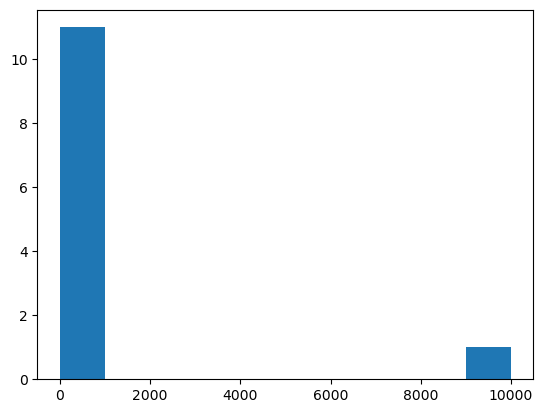

In [1]:
import matplotlib.pyplot as plt
x = [1,10,20,30,50,75,100,125,150,200,1000,10000]
plt.hist(x)
plt.show()

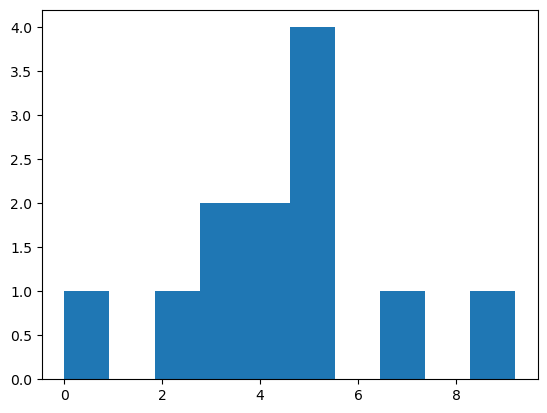

In [2]:
import numpy as np
plt.hist(np.log(x))
plt.show()

#### As usual, we'll get going with a few package imports that we'll use along the way
"BeautifulSoup" (from bs4) is the all important python module that can parse html (and xml, in exactly the same way), "requests" let's us request page html from the internet, "re" is the regular expressions package, "string" literally just gets us the 26 letters of the alphabet in order, and "json" helps us read and write json protocol data.

In [3]:
from bs4 import BeautifulSoup
import requests, re, string, json

#### Let's look again at some very simple html
Notice that there are lots of "tags." These are the keys for our data, and the content between pairs of tags are the values.

In [4]:
html = requests.get("http://www.example.com").text
print(html)

<!doctype html>
<html>
<head>
    <title>Example Domain</title>

    <meta charset="utf-8" />
    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1" />
    <style type="text/css">
    body {
        background-color: #f0f0f2;
        margin: 0;
        padding: 0;
        font-family: -apple-system, system-ui, BlinkMacSystemFont, "Segoe UI", "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;
        
    }
    div {
        width: 600px;
        margin: 5em auto;
        padding: 2em;
        background-color: #fdfdff;
        border-radius: 0.5em;
        box-shadow: 2px 3px 7px 2px rgba(0,0,0,0.02);
    }
    a:link, a:visited {
        color: #38488f;
        text-decoration: none;
    }
    @media (max-width: 700px) {
        div {
            margin: 0 auto;
            width: auto;
        }
    }
    </style>    
</head>

<body>
<div>
    <h1>Example Domain</h1>
    <p>This domai

#### Time to parse the html with BeautifulSoup()
After parsing, we can use the .find() function see a particular tag-value as html markup. Here's the head.

In [5]:
soup = BeautifulSoup(html, 'lxml')
print(soup.find('head'))

<head>
<title>Example Domain</title>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<style type="text/css">
    body {
        background-color: #f0f0f2;
        margin: 0;
        padding: 0;
        font-family: -apple-system, system-ui, BlinkMacSystemFont, "Segoe UI", "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;
        
    }
    div {
        width: 600px;
        margin: 5em auto;
        padding: 2em;
        background-color: #fdfdff;
        border-radius: 0.5em;
        box-shadow: 2px 3px 7px 2px rgba(0,0,0,0.02);
    }
    a:link, a:visited {
        color: #38488f;
        text-decoration: none;
    }
    @media (max-width: 700px) {
        div {
            margin: 0 auto;
            width: auto;
        }
    }
    </style>
</head>


#### Tags are nested
This is just a good old fashioned associative array!

In [6]:
print(soup.find('head').find('title'))

<title>Example Domain</title>


#### How to get the "data"
To get what's inside of a particular tag, we use the .text attribute at any particular level

In [7]:
print(soup.find('head').find('title').text)

Example Domain


### For webpages, the goods are generally inside of the 'body'

In [8]:
print(soup.find('body'))

<body>
<div>
<h1>Example Domain</h1>
<p>This domain is for use in illustrative examples in documents. You may use this
    domain in literature without prior coordination or asking for permission.</p>
<p><a href="https://www.iana.org/domains/example">More information...</a></p>
</div>
</body>


#### You don't actually have to follow nesting
If you want was inside of any 'p' tag, you can leave out nesting specifications. Here, we've left out that we want the 'body' specifically, although that's all there really is.

In [9]:
print(soup.find('p').text)

This domain is for use in illustrative examples in documents. You may use this
    domain in literature without prior coordination or asking for permission.


#### And if there's more than one of the same attribute
Use the .find_all() function.

In [10]:
print(soup.find_all('p'))

[<p>This domain is for use in illustrative examples in documents. You may use this
    domain in literature without prior coordination or asking for permission.</p>, <p><a href="https://www.iana.org/domains/example">More information...</a></p>]


Since the result is a list, you can now iterate to see the individual elements.

In [11]:
for par in soup.find_all('p'):
    print(par)

<p>This domain is for use in illustrative examples in documents. You may use this
    domain in literature without prior coordination or asking for permission.</p>
<p><a href="https://www.iana.org/domains/example">More information...</a></p>


#### Let's look at some links
Links are super important, and are generally in the 'a' tags, but as an "href=..." attribute. To get attributes, we first have to find tags. With a tag in hand, you can access any attribute using its name like a dictionary key.

In [10]:
print(soup.find('a'))
print("")
print(soup.find('a').text)
print("")
print(soup.find('a')['href'])

<a href="http://www.iana.org/domains/example">More information...</a>

More information...

http://www.iana.org/domains/example


#### Spreading out
This is where things really get interesting. Scraping the web for one page isn't very interesting. Remember, the web is a big network of connected pages. Some are internal to a site, and some are external. This little page has one outlink. Let's follow it and see what's on the next page, by downloading and parsing the html behind the next link. Note: in the list of links we find on the next page, some are external/complete and start with http://..., and some are site internal and start with a slash ("/").

In [12]:
newhtml = requests.get(soup.find('a')['href']).text
newsoup = BeautifulSoup(newhtml, 'lxml')

for link in newsoup.find_all('a'):
    print(link['href'])

/
/domains
/protocols
/numbers
/about
/go/rfc2606
/go/rfc6761
/domains/reserved
/domains
/domains/root
/domains/int
/domains/arpa
/domains/idn-tables
/numbers
/abuse
/protocols
/protocols
/time-zones
/about
/performance
/reports
/reviews
/about/excellence
/contact
http://pti.icann.org
http://www.icann.org/
https://www.icann.org/privacy/policy
https://www.icann.org/privacy/tos


#### The world is much more complex
Our first, example page was VERY simple, and this next one even has multiple 'p' tags. However, as we'll see below things get much more complicated.

In [13]:
for par in newsoup.find_all('p'):
    print(par.text)
    print("")

As described in RFC 2606 and RFC 6761, a
number of domains such as example.com and example.org are maintained
for documentation purposes. These domains may be used as illustrative
examples in documents without prior coordination with us. They are not
available for registration or transfer.

We provide a web service on the example domain hosts to provide basic
information on the purpose of the domain. These web services are
provided as best effort, but are not designed to support production
applications. While incidental traffic for incorrectly configured
applications is expected, please do not design applications that require
the example domains to have operating HTTP service.

The IANA functions coordinate the Internet’s globally unique identifiers, and
                are provided by Public Technical Identifiers, an affiliate of
                ICANN.



## Downloading a personal copy of the song lyrics
Here's a fun challenge: can we go to one of those big song lyrics websites and grab everything they've got? Yes, but there are a number of challenges that go beyond control flow and syntax stuff:

* Understanding the terms of use
* Determining website (page-page) structure
* Strategizing how to cover the whole site
* Deciding which data to look for
* Finding out where that data is stored
* Determing a good data structure (schema)
* Determinging a storage structure (files and directories)

We're gonna go for songlyrics.com, but let's start by taking a look at the terms and conditions. For fun, we'll take a look with beautiful soup. What a mess...

In [14]:
html = requests.get("http://www.songlyrics.com/termsconditions.php").text
soup = BeautifulSoup(html, 'lxml')
print(html)

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "https://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="https://www.w3.org/1999/xhtml" lang="en-US">
<head>
	<title>Terms and Conditions | Collection of Song Lyrics at SongLyrics.com</title>
	<meta http-equiv="content-type" content="text/html; charset=utf-8" />
	<meta name="description" content="" />
	
	<meta name="msvalidate.01" content="CF28C9C2E5FDBD5C7CA7F6FE394BD121" />
			<meta name="robots" content="noydir, noodp" />
		<meta property="fb:admins" content="31113169,100000933112467,1383859676" />
	<meta name="fb:app_id" content="1418134321780018" />
	<meta name="viewport" content="width=device-width, initial-scale=1"> <!-- viewport -->
	
	<link rel="preconnect" href="https://www.songlyrics.com" />
	<link rel="dns-prefetch" href="//static.songlyrics.com />
	<link rel="dns-prefetch" href="//googleads.g.doubleclick.net" />

	<link rel="icon" href="favicon.ico" type="image/ico" />
	<link href="css/global.mi

#### Finding the structure
Let's see if we can get a hint by looking at the div class (css) names. The 'maintext' class might be a good one.

In [15]:
for div in soup.body.find_all('div'):
    print(div.get('class'))

None
None
None
['headinner']
None
None
None
None
None
None
['headinner']
None
['submit-btn']
['headinner']
None
['submit-btn']
None
None
None
['masthead']
['wrapper-inner']
['topnav']
['pw_widget', 'pw_size_24', 'pw_post_false', 'pw_counter_true']
None
['colone-wide']
['maintext', 'padder']
['colthree']
['adblock']
['box']
['listbox']
None
['footer']
None


#### Getting to the point
In the maintext class, there are headers ('h1', 'h2', etc...) and paragraphs ('p') that contain the content, and to get them both in the right order, we'll need to be flexible. BeautifulSoup can do this with some regular expressions useing re.compile(). Here a simple one that says "I'll take anything that has an h or p". Notice in the "Use of Material" section that is says I can download a single copy of the material on the website! Yay, this means I can take one copy?

In [16]:
for div in soup.body.find_all('div'):
    if div.get('class') is not None:
        if div['class'][0] == 'maintext':
            for element in div.find_all(re.compile('h|p')):
                print(element.text)
                print("")

Terms and Conditions

This page contains the "Terms and Conditions" under which you may use www.SongLyrics.com. Please read this page carefully. If you do not accept the Terms and Conditions stated here, do not use this web site and service. By using this web site, you are indicating your acceptance to be bound by the terms of these Terms and Conditions. SongLyrics.com, (the "Company") owner of SongLyrics.com.com, may revise these Terms and Conditions at any time by updating this posting. You should visit this page periodically to review the Terms and Conditions, because they are binding on you and may change without notice. The terms "You" and "User" as used herein refer to all individuals and/or entities accessing this web site for any reason.

Use of Material. 

The Company authorizes you to view and download a single copy of the material on SongLyrics.com.com (the "Web Site") solely for your personal, noncommercial use. 

The contents of this Web Site, such as text, graphics, image

#### Looking at the letter 'a'
SongLyrics stores their song lyrics in a very nice a-z artists index. So, we'll play around with the letter 'a'. Let's look at the html for this. Of course, they don't just present ALL artists, the information is paginated! So, we'll have to jump in to each of the subdirectories for this letter, but first we need to gather these links.

In [17]:
html = requests.get("http://www.songlyrics.com/a/").text
soup = BeautifulSoup(html, 'lxml')
print(html)

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "https://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="https://www.w3.org/1999/xhtml" lang="en-US">
<head>
	<title>A Artist Song Lyrics</title>
	<meta http-equiv="content-type" content="text/html; charset=utf-8" />
	<meta name="description" content="Song lyrics for artists that start with the letter A." />
	
	<meta name="msvalidate.01" content="CF28C9C2E5FDBD5C7CA7F6FE394BD121" />
			<meta name="robots" content="noydir, noodp" />
		<meta property="fb:admins" content="31113169,100000933112467,1383859676" />
	<meta name="fb:app_id" content="1418134321780018" />
	<meta name="viewport" content="width=device-width, initial-scale=1"> <!-- viewport -->
	
	<link rel="preconnect" href="https://www.songlyrics.com" />
	<link rel="dns-prefetch" href="//static.songlyrics.com />
	<link rel="dns-prefetch" href="//googleads.g.doubleclick.net" />

	<link rel="icon" href="favicon.ico" type="image/ico" />
	<link href="css/gl

#### Regular expressions help to filter the individual link objects
It's easy enough to get links, but we just want the ones with a title of the form "Page #". So, using the "re" module once again, but now on the page titles of the links gets us what we want. Also, since there are a few artists on the landing page for each letter, we need to include it, too.

In [18]:
pages = ["/a/"]
for x in soup.find_all('a'):
    if x.get("href") is not None and re.search("^Page \d+$", x.get("title", "NOTITLE")):
        print(x['href'])
        pages.append(x['href'])

/a/1/
/a/2/
/a/3/
/a/4/
/a/5/
/a/6/
/a/7/
/a/8/
/a/9/
/a/10/
/a/11/
/a/12/
/a/13/
/a/14/
/a/15/
/a/16/
/a/17/
/a/18/
/a/19/
/a/20/
/a/21/
/a/22/
/a/23/
/a/24/
/a/25/
/a/26/
/a/27/
/a/28/
/a/29/
/a/30/
/a/31/
/a/32/
/a/33/
/a/34/
/a/35/
/a/36/
/a/37/
/a/38/
/a/39/
/a/40/
/a/41/
/a/42/
/a/43/
/a/44/
/a/45/
/a/46/
/a/47/
/a/48/
/a/49/
/a/50/
/a/51/
/a/52/
/a/53/
/a/54/
/a/55/
/a/56/
/a/57/
/a/58/
/a/59/
/a/60/
/a/61/
/a/62/
/a/63/
/a/64/
/a/65/
/a/66/
/a/67/
/a/68/
/a/69/
/a/70/
/a/71/
/a/72/
/a/73/
/a/74/
/a/75/
/a/76/
/a/77/
/a/78/
/a/79/
/a/80/
/a/81/
/a/82/
/a/83/
/a/84/
/a/85/
/a/86/
/a/87/
/a/88/
/a/89/
/a/90/
/a/91/
/a/92/
/a/93/
/a/94/
/a/95/
/a/96/
/a/97/
/a/98/
/a/99/
/a/100/
/a/101/
/a/102/
/a/103/
/a/104/
/a/105/
/a/106/
/a/107/
/a/108/
/a/109/
/a/110/
/a/111/
/a/112/
/a/113/
/a/114/
/a/115/
/a/116/
/a/117/
/a/118/
/a/119/
/a/120/
/a/121/
/a/122/
/a/123/
/a/124/
/a/125/
/a/126/
/a/127/
/a/128/
/a/129/
/a/130/
/a/131/
/a/132/
/a/133/
/a/134/
/a/135/
/a/136/
/a/137/
/a/138/
/a/1

#### Follow the directory tree!
Now that we've got the pages, its' time to put urls together off of the main site. Notice the string "+" in the requests.get() command. From there, we can see what links are in the first page! Looks like the listing is there again, but the artist's pages are in the full-url pattern:

* http://www.songlyrics.com/ARTISTNAME-lyrics.html

In [19]:
for page in pages:
    
    html = requests.get("http://www.songlyrics.com"+page).text
    soup = BeautifulSoup(html, 'lxml')
    for x in soup.find_all('a'):
        if x.get("href") is not None:
            print(x['href'])
    
    break
   

/
/top-songs-lyrics.html
/top100.php
/top-upcoming-songs.html
/latestAddedSongs
/news/top-songs/2011/
/news/top-songs/2010/
/news/top-songs/2009/
/news/top-songs/all-time/
/top-artists-lyrics.html
/top-artists-lyrics.html
/a/
/top-albums-lyrics.html
/top-upcoming-albums.html
/adele-lyrics/
/rihanna-lyrics/
/katy-perry-lyrics/
/lady-gaga-lyrics/
/lil-wayne-lyrics/
/musicgenres.php
/rock-lyrics.php
/r-and-b-lyrics.php
/country-music-lyrics.php
/hip-hop-rap-lyrics.php
/pop-lyrics.php
/christian-lyrics.php
/dance-lyrics.php
/latin-lyrics.php
/musicgenres.php
/news/
/news/
/news/category/news-roundup/
/news/album-reviews/
/news/album-reviews/
/news/category/song-reviews/
/news/category/spotlight/
/member-login.php
/member-register.php
https://www.facebook.com/SongLyrics
/news/advertise/
/news/submit-lyrics/
#nav
#
/
/top-songs-lyrics.html
/top100.php
/top-upcoming-songs.html
/latestAddedSongs
/news/top-songs/2011/
/news/top-songs/2010/
/news/top-songs/2009/
/news/top-songs/all-time/
/top-ar

#### Filtering for full urls
Notice also that artist's urls are terminated by the word 'lyrics'. We'll use this regularity, too. Also, since we are digging into the data for a given artist, it's time to create our data structure. Each artist will be a separate data dictionary, and we'll start by storing their name and the url for their main page. For an individual artist, the data schema will be: 
```
{
    "Artist": name,
    "url": artist-url,
    "Songs": {
        title1: {
            "Title": title1,
            "url": title1-url,
            "Lyrics": title1-lyrics,
            "Artist": title1-artist,
            "Genre": title1-genre,
            "Album": title1-album,
            ...
        },
        ...
    }
}
```
where as it turns out, we will be able to store all additional meta-data attributes that are present, like "Genre", "Album", "Note", etc.

In [32]:
for page in pages:
    html = requests.get("http://www.songlyrics.com"+page).text
    soup = BeautifulSoup(html, 'lxml')
    for x in soup.find_all('a'):
        if re.search("^https://.*?-lyrics/$",x.get("href", "NOLINK")):
            data = {
                "Artist": x.text,
                "url": x['href'],
                "Songs": {}
            }
            break
    break
print(data["url"])

https://www.songlyrics.com/a--lyrics/


#### Links for an artist
Now it's time to find the songs for the individual artists. These are once again the links, so let's see. It looks like the song links tend to have the `'itemprop'` attribute, but is this enought to cleanly filter them?

In [23]:
html = requests.get(data["url"]).text
soup = BeautifulSoup(html, 'lxml')
for link in soup.find_all('a'):
    print(link)

<a href="/">Lyrics</a>
<a href="/top-songs-lyrics.html">Popular Song Lyrics</a>
<a href="/top100.php">Billboard Hot 100</a>
<a href="/top-upcoming-songs.html">Upcoming Lyrics</a>
<a href="/latestAddedSongs">Recently Added</a>
<a href="/news/top-songs/2011/">Top Lyrics of 2011</a>
<a href="/news/top-songs/2010/">Top Lyrics of 2010</a>
<a href="/news/top-songs/2009/">Top Lyrics of 2009</a>
<a href="/news/top-songs/all-time/">More »</a>
<a href="/top-artists-lyrics.html">Artists</a>
<a href="/top-artists-lyrics.html">Popular Artists</a>
<a href="/a/">Artists A-Z</a>
<a href="/top-albums-lyrics.html">Popular Albums</a>
<a href="/top-upcoming-albums.html">Upcoming Albums</a>
<a href="/adele-lyrics/">Adele</a>
<a href="/rihanna-lyrics/">Rihanna</a>
<a href="/katy-perry-lyrics/">Katy Perry</a>
<a href="/lady-gaga-lyrics/">Lady Gaga</a>
<a href="/lil-wayne-lyrics/">Lil Wayne</a>
<a href="/musicgenres.php">Genres</a>
<a href="/rock-lyrics.php" title="Rock Lyrics">Rock</a>
<a href="/r-and-b-lyri

#### Filtering for the songs
Filtering for songs by the `'itemprop'` attribute turns out now to be good enough. Several other links have this tag, specifically, those for the two steps back in the directory structure. 

In [24]:
for link in soup.find_all('a'):
    if link.get("itemprop") is not None:
        print(link)

<a href="https://www.songlyrics.com/" itemprop="item"><span itemprop="name">Song Lyrics</span></a>
<a href="https://www.songlyrics.com/a/" itemprop="item"><span itemprop="name">Artists - A</span></a>
<a href="https://www.songlyrics.com/a/a-z-lyrics/" itemprop="url" title="A+Z Lyrics A">A+Z</a>
<a href="https://www.songlyrics.com/a/owner-of-a-lonely-heart-lyrics/" itemprop="url" title="Owner Of A Lonely Heart Lyrics A">Owner Of A Lonely Heart</a>
<a href="https://www.songlyrics.com/a/going-down-lyrics/" itemprop="url" title="Going Down Lyrics A">Going Down</a>
<a href="https://www.songlyrics.com/a/hi-fi-serious-lyrics/" itemprop="url" title="Hi-Fi Serious Lyrics A">Hi-Fi Serious</a>
<a href="https://www.songlyrics.com/a/something-s-going-on-lyrics/" itemprop="url" title="Something's Going On Lyrics A">Something's Going On</a>
<a href="https://www.songlyrics.com/a/starbucks-lyrics/" itemprop="url" title="Starbucks Lyrics A">Starbucks</a>
<a href="https://www.songlyrics.com/a/pacific-ocea

#### Honing in on the songs
Since songs also have a title, we can additionally specify for a title to get the relevant links.

In [25]:
for link in soup.find_all('a'):
    if link.get("itemprop", "NOITEMPROP") == "url" and link.get("title") is not None:        
        data["Songs"][link.text] = {"Title": link.text}
        data["Songs"][link.text]["url"] = link['href']
        print(link['href'], link.text)

https://www.songlyrics.com/a/a-z-lyrics/ A+Z
https://www.songlyrics.com/a/owner-of-a-lonely-heart-lyrics/ Owner Of A Lonely Heart
https://www.songlyrics.com/a/going-down-lyrics/ Going Down
https://www.songlyrics.com/a/hi-fi-serious-lyrics/ Hi-Fi Serious
https://www.songlyrics.com/a/something-s-going-on-lyrics/ Something's Going On
https://www.songlyrics.com/a/starbucks-lyrics/ Starbucks
https://www.songlyrics.com/a/pacific-ocean-blue-lyrics/ Pacific Ocean Blue
https://www.songlyrics.com/a/6-o-clock-on-a-tube-stop-lyrics/ 6 O'Clock On a Tube Stop
https://www.songlyrics.com/a/shut-yer-face-lyrics/ Shut Yer Face
https://www.songlyrics.com/a/bad-idea-lyrics/ Bad Idea
https://www.songlyrics.com/a/rush-song-lyrics/ Rush Song
https://www.songlyrics.com/a/the-art-of-making-sense-lyrics/ The Art Of Making Sense
https://www.songlyrics.com/a/enjoy-yourself-lyrics/ Enjoy Yourself
https://www.songlyrics.com/a/the-distance-lyrics/ The Distance
https://www.songlyrics.com/a/all-i-see-lyrics/ All I See

#### Finally, some lyrics
Now that we have the song links, let's see if we can find our target data, the song lyrics, along with anything else that's good, like the genre and album. Going straight for the body, this is still a mess. 

In [ ]:
for title in data["Songs"]:
    html = requests.get(data["Songs"][title]["url"]).text
    soup = BeautifulSoup(html, 'lxml')
    print(soup.find('body'))
   

<body>
<script>
	/* BIT - 1x1 - Songlyrics.com - Video */
	cf_page_artist = "";
	cf_page_song = "";
	cf_adunit_id = "100005353";
</script>
<script src="//srv.tunefindforfans.com/fruits/apricots.js"></script>
<div id="fb-root"></div>
<div id="header">
<div id="headernav">
<div class="headinner">
<ul class="menu floatleft">
<li class="mega">
<h2><a href="/">Lyrics</a></h2>
<div>
<p><a href="/top-songs-lyrics.html">Popular Song Lyrics</a></p>
<p><a href="/top100.php">Billboard Hot 100</a></p>
<p><a href="/top-upcoming-songs.html">Upcoming Lyrics</a></p>
<p><a href="/latestAddedSongs">Recently Added</a></p>
<p class="menu-hr"></p>
<p><a href="/news/top-songs/2011/">Top Lyrics of 2011</a></p>
<p><a href="/news/top-songs/2010/">Top Lyrics of 2010</a></p>
<p><a href="/news/top-songs/2009/">Top Lyrics of 2009</a></p>
<p><a href="/news/top-songs/all-time/">More »</a></p>
</div>
</li>
<li class="mega">
<h2><a href="/top-artists-lyrics.html">Artists</a></h2>
<div>
<p><a href="/top-artists-lyrics.

#### Extracting the data
Scanning closely (or matching the rendered web sites content text), we can see that the actual lyrics are inside of a div with the `'songLyricsDiv-outer'` id. That's easy to collect, since we just want the text from this div (and there's only one). Getting the meta-data, e.g., album, is a bit more complicated. The meta-data comes just under the the `'h1'` title as a link, between `'p'` tags. Notice additionally that meta-data attributes come in the text format `'key: value'`. So, filtering `'p'` tag text for colon-space, ": ", we get what we want. However these entries are much more useful if we actually parse them into keys and values, e.g., transform `"Genre: Rock"` into a python dictionary `{"Genre": "Rock"}`. This is done with the `re.split()` command, delimiting by any first `": "`. Any meta-data attributes and the lyrics themselves are then stored in the artists data dictionary, and we're done with the song! Phew!

In [24]:
for title in data["Songs"]:
    html = requests.get(data["Songs"][title]["url"]).text
    soup = BeautifulSoup(html, 'lxml')
    for par in soup.find_all("p"):
        if re.search(": ", par.text):
            pieces = re.split(": ", par.text)
            key = pieces[0]
            value = ": ".join(pieces[1:len(pieces)])
            data["Songs"][title][key] = value    
    for div in soup.find('body').find_all('div'):
        if div.get("id","NOCLASS") == "songLyricsDiv-outer":
            data["Songs"][title]["Lyrics"]=div.text
    for key in data["Songs"][title]:
        print(key+": ", data["Songs"][title][key])
        print("")
    break

Title:  Sing-A-Long

url:  http://www.songlyrics.com/a/sing-a-long-lyrics/

Artist:  A

Album:  Miscellaneous

Genre:  Rock

Note:  When you embed the widget in your site, it will match your site's styles (CSS). This is just a preview!

Lyrics:  
Everybody in the building
Has to sing the song
All the boys and all the girlfriends
Sing the sing-a-long

Think I'm in trouble
There's always a couple
Around me wherever I go

They're out there to bug me
I don't think it's funny
Everybody's laughing at me, yeah

I wanna go out
But there's no one about
All my friends
Want a quiet one at home

The same age as me and
They're husbands to be, yeah
Everybody in the building

Everybody in the building
Has to sing the song
All the boys and all the girlfriends
Sing the sing-a-long

I make a move here
And I make a move there
I've got millions of things
On the go

I write me the best lines
They're too corny sometimes
Everybody's laughing at me

Everybody in the building
Has to sing the song
All the boys 

#### Putting everything together
Now that we have all of the essential details for our code, it's time to put them together into a single script. The following does this, but now without changing some of the names to avoid variable collisions. Additionally, since we are trying to download ALL of the data here, we need to store it in a reasonably-convenient file structure. So, creatign separate files for each letter of the alphabet, we'll make each artist a line of json data. Note that for testing, this code still has breaks to finish after the first song.

In [25]:
## go through all of the letters in the alphabet
for letter in string.ascii_lowercase:
    
    ## create a data file for the current letter
    filename = "songlyrics-"+letter+".json"
    fh = open(filename,  "w")
    fh.close()
    
    ## open and parse the html for the current letter
    letterhtml = requests.get("http://www.songlyrics.com/"+letter+"/").text
    lettersoup = BeautifulSoup(letterhtml, 'lxml')

    ## collect the pages for this letter
    pages = ["/"+letter+"/"]
    for letterlink in lettersoup.find_all('a'):
        ## filter links for letter pages
        if letterlink.get("href") is not None and re.search("^Page \d+$", letterlink.get("title", "NOTITLE")):            
            pages.append(letterlink['href'])

    ## go through the letter pages
    for page in pages:        
        ## open and parse the html for the current page of this letter
        pagehtml = requests.get("http://www.songlyrics.com"+page).text
        pagesoup = BeautifulSoup(pagehtml, 'lxml')

        ## go through the artists in the page
        for pagelink in pagesoup.find_all('a'):
            ## filter links for artist pages
            if re.search("^http://.*?-lyrics/$",pagelink.get("href", "NOLINK")):
                ## set up data and store artist-level information
                data = {
                    "Artist": pagelink.text,
                    "url": pagelink['href'],
                    "Songs": {}
                }

                ## open and parse the html for the current artist on this page
                artisthtml = requests.get(data["url"]).text
                artistsoup = BeautifulSoup(artisthtml, 'lxml')                        

                ## go through the songs of this artist
                for songlink in artistsoup.find_all('a'):

                    ## filter links for song pages
                    if songlink.get("itemprop", "NOITEMPROP") == "url" and songlink.get("title") is not None:

                        ## store initial song-level information
                        title = songlink.text
                        data["Songs"][title] = {"Title": title}
                        data["Songs"][title]["url"] = songlink['href']

                        ## open and parse the html for the current song by this artist
                        songhtml = requests.get(data["Songs"][title]["url"]).text
                        songsoup = BeautifulSoup(songhtml, 'lxml')

                        ## go through paragraphs to find song attributes
                        for par in songsoup.find_all("p"):
                            if re.search(": ", par.text):
                                pieces = re.split(": ", par.text)
                                key = pieces[0]
                                value = ": ".join(pieces[1:len(pieces)])
                                data["Songs"][title][key] = value    

                        ## go through divs to find the one with the song lyrics
                        for div in songsoup.find('body').find_all('div'):
                            if div.get("id","NOCLASS") == "songLyricsDiv-outer":
                                data["Songs"][title]["Lyrics"]=div.text
                        break

                ## write out the data for this artist, appending to the end of this letter's file
                with open(filename, "a") as fh:
                    fh.writelines(json.dumps(data)+"\n")
                break
        break
    break

#### Always double check your output is good before running at scale...
It's always good to stop and make sure your output data is as you believe it will be. Here, we'll just load in what we've outputted to see if it's actually the data we got from testing.

In [3]:
with open("songlyrics-a.json", "r") as f:
    data = json.loads(f.read())
for key in data:
    print(key, data[key])

Artist A
url http://www.songlyrics.com/a--lyrics/
Songs {'Sing-A-Long': {'Title': 'Sing-A-Long', 'url': 'http://www.songlyrics.com/a/sing-a-long-lyrics/', 'Artist': 'A', 'Album': 'Miscellaneous', 'Genre': 'Rock', 'Note': "When you embed the widget in your site, it will match your site's styles (CSS). This is just a preview!", 'Lyrics': "\nEverybody in the building\nHas to sing the song\nAll the boys and all the girlfriends\nSing the sing-a-long\n\nThink I'm in trouble\nThere's always a couple\nAround me wherever I go\n\nThey're out there to bug me\nI don't think it's funny\nEverybody's laughing at me, yeah\n\nI wanna go out\nBut there's no one about\nAll my friends\nWant a quiet one at home\n\nThe same age as me and\nThey're husbands to be, yeah\nEverybody in the building\n\nEverybody in the building\nHas to sing the song\nAll the boys and all the girlfriends\nSing the sing-a-long\n\nI make a move here\nAnd I make a move there\nI've got millions of things\nOn the go\n\nI write me the b

In [4]:
with open("songlyrics-a.json", "r") as f:
    data = json.loads(f.read())
print(data)

{'Artist': 'A', 'url': 'http://www.songlyrics.com/a--lyrics/', 'Songs': {'Sing-A-Long': {'Title': 'Sing-A-Long', 'url': 'http://www.songlyrics.com/a/sing-a-long-lyrics/', 'Artist': 'A', 'Album': 'Miscellaneous', 'Genre': 'Rock', 'Note': "When you embed the widget in your site, it will match your site's styles (CSS). This is just a preview!", 'Lyrics': "\nEverybody in the building\nHas to sing the song\nAll the boys and all the girlfriends\nSing the sing-a-long\n\nThink I'm in trouble\nThere's always a couple\nAround me wherever I go\n\nThey're out there to bug me\nI don't think it's funny\nEverybody's laughing at me, yeah\n\nI wanna go out\nBut there's no one about\nAll my friends\nWant a quiet one at home\n\nThe same age as me and\nThey're husbands to be, yeah\nEverybody in the building\n\nEverybody in the building\nHas to sing the song\nAll the boys and all the girlfriends\nSing the sing-a-long\n\nI make a move here\nAnd I make a move there\nI've got millions of things\nOn the go\n\n